[Hyun woo kim]  - 2018-10-19 

I changed the kernel to match the changed dataset. The changes are summarized in the kernel below.
https://www.kaggle.com/chocozzz/updated-what-is-difference-before-data

![](https://storage.googleapis.com/kaggle-media/competitions/PUBG/PUBG%20Inlay.jpg)

## Notebook Outline
- Competition Description
- Game Description
- Variable Description
- Simple EDA 
- Feature Engineering
- LightGBM

## 1. Competiton Description

Description : So, where we droppin' boys and girls?

Battle Royale-style video games have taken the world by storm. 100 players are dropped onto an island empty-handed and must explore, scavenge, and eliminate other players until only one is left standing, all while the play zone continues to shrink.
> 大逃杀风格的电子游戏风靡全球。 100名玩家空手落在一个岛上，必须探索，捡拾并消灭其他玩家，直到只剩下一个玩家站立为止，而整个游戏区一直在缩小。

PlayerUnknown's BattleGrounds (PUBG) has enjoyed massive popularity. With over 50 million copies sold, it's the fifth best selling game of all time, and has millions of active monthly players.
> PlayerUnknown的BattleGrounds（PUBG）享有很高的知名度。该游戏销量超过5,000万册，是有史以来销量排名第五的游戏，每月活跃玩家达数百万。

The team at [PUBG](https://www.pubg.com/) has made official game data available for the public to explore and scavenge outside of "The Blue Circle." This competition is not an official or affiliated PUBG site - Kaggle collected data made possible through the [PUBG Developer API.](https://developer.pubg.com/)
> PUBG]（https://www.pubg.com/）上的团队已向公众提供了官方游戏数据，供公众在“蓝色圆圈”之外进行探索和清理。该竞赛不是PUBG的官方网站或附属网站-Kaggle通过[PUBG Developer API]收集了可能的数据。（https://developer.pubg.com/）

You are given over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings.
> 系统会为您提供超过65,000个游戏的匿名玩家数据，将其分为训练和测试集，并要求您根据最终的游戏统计数据和初始玩家等级来预测最终排名。

What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot? Let's let the data do the talking!
> 赢得PUBG的最佳策略是什么？您应该坐在一个位置并躲藏在通往胜利的道路中，还是需要成为头号人物？让数据说话！

## 2. Game Description

I will try this game and know what it is but I will introduce the game simply for those who do not know. This game is a kind of Survival game that goes around a certain field and makes a fight. I have attached the game video to the link below. So it would be better to understand data

> 我将尝试该游戏并知道它是什么，但是我将仅为那些不知道的人介绍该游戏。该游戏是一种生存游戏，它围绕特定领域进行战斗。我已将游戏视频附加到下面的链接。因此最好理解数据

Video Link : https://www.youtube.com/watch?v=rmyyeqQpHQc

In [1]:
import pandas as pd # Analysis 
import matplotlib.pyplot as plt # Visulization
import seaborn as sns # Visulization
import numpy as np # Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler # Analysis 
from scipy import stats # Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
# plotly 可视化神器
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import gc

In [2]:
#If you run all dataset, you change debug False
debug = False
if debug == True:
    df_train = pd.read_csv('../data/train_V2.csv', nrows=10000)
    df_test  = pd.read_csv('../data/test_V2.csv')
else:
    df_train = pd.read_csv('../data/train_V2.csv')
    df_test  = pd.read_csv('../data/test_V2.csv')

In [3]:
print("Train : ",df_train.shape)
print("Test : ",df_test.shape)

Train :  (4446966, 29)
Test :  (1934174, 28)


In [4]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


#### reduce memory

In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

## 3. Variable Description

### What is difference Id, groupId, matchId ?

In the data description,   
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time. 

In [6]:
df_train[df_train['groupId']=='4d4b580de459be']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0,0,0.0,0,0,244.75000,1,1466,0.444336
903525,7516514fbd1091,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,62,...,0,0.0,0,0.0,0,0,48.28125,1,1465,0.444336
1912681,c56d45be16aa86,4d4b580de459be,a10357fd1a4a91,0,0,318.00,2,1,0,6,...,0,0.0,0,0.0,0,0,342.75000,2,1476,0.444336
2383840,100eef17c4d773,4d4b580de459be,a10357fd1a4a91,0,0,90.75,0,0,0,61,...,0,0.0,0,0.0,0,0,96.06250,1,1498,0.444336


In [7]:
len(df_train[df_train['matchId']=='a10357fd1a4a91'])

96

Consider the example above. In both cases Id is different, but groupId and matchId are the same. To illustrate this, a person A with an Id 7f96b2f878858a and a person B with an ID 7516514fbd1091 are friends and have a team together (groupId). Then the same match is done, so you can assume that they entered the game with the same matchId.
> 考虑上面的例子。在这两种情况下，Id是不同的，但是groupId和matchId是相同的。为了说明这一点，Id为7f96b2f878858a的a和Id为7516514fbd1091的B是朋友，并且有一个团队(groupId)。然后进行相同的匹配，因此可以假设他们使用相同的matchId进入游戏。

To put it another way, Battlegrounds (PBUGs) have a total about 100 people per game. These 100 players have the same matchId. Among them, groupId are same as 4d4b580de459be, so you can think that they are friends  and joined the team and played together. (There are about 100 people, not necessarily 100 people.)
> 换句话说，《Battlegrounds》(PBUGs)每局大约有100名玩家。这100个玩家拥有相同的matchId。其中groupId和4d4b580de459be是一样的，所以你可以认为他们是朋友，加入了团队，一起玩。(大约有100人，不一定是100人。)

In [8]:
temp = df_train[df_train['matchId']=='a10357fd1a4a91']['groupId'].value_counts().sort_values(ascending=False)
print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
display(temp)
display(trace)

Total number of states :  26


654c638629b8fc    8
80d9f9014c6e68    7
edbce070d4ee9d    5
432b8256f23c7e    5
a269f08371068b    5
3fe42857a5d0e3    4
e3b971e00acee4    4
4d4b580de459be    4
7e5fb71e05a678    4
5ddf679672a972    4
74898d59ac4879    4
69c3ba1a23df2a    4
5112ebf44e9575    4
92a09f0a596787    4
64903e9ba2e503    4
d7d1cd054b0f5b    3
2f8336736f3be2    3
2af5c87d86546d    3
c92eb4405f4d3a    3
e93dfe8291d05c    3
168d1fc8ebe03c    3
a27667dbecd7d7    2
30e393959e45ac    2
0b4bf93ca082a4    2
1d31d15e045c4d    1
2cdf256e3c2c1d    1
Name: groupId, dtype: int64

Bar({
    'x': array(['654c638629b8fc', '80d9f9014c6e68', 'edbce070d4ee9d', '432b8256f23c7e',
                'a269f08371068b', '3fe42857a5d0e3', 'e3b971e00acee4', '4d4b580de459be',
                '7e5fb71e05a678', '5ddf679672a972', '74898d59ac4879', '69c3ba1a23df2a',
                '5112ebf44e9575', '92a09f0a596787', '64903e9ba2e503', 'd7d1cd054b0f5b',
                '2f8336736f3be2', '2af5c87d86546d', 'c92eb4405f4d3a', 'e93dfe8291d05c',
                '168d1fc8ebe03c', 'a27667dbecd7d7', '30e393959e45ac', '0b4bf93ca082a4',
                '1d31d15e045c4d', '2cdf256e3c2c1d'], dtype=object),
    'y': array([8, 7, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2,
                1, 1])
})

In [9]:
data = [trace]
layout = go.Layout(
    title = "GroupId of Match Id: a10357fd1a4a91",
    xaxis=dict(# x轴
        title='groupId',# x 轴标题
        tickfont=dict( # x轴tick 字体颜色
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of groupId of type of MatchId a10357fd1a4a91',# y轴标题
        titlefont=dict(# y轴标题字体
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(# y轴tick字体
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig , filename='schoolStateNames')

**Note :**  You can see something strange in value counts. Four people are maximum team member and I do not know what it means more than four people. 
> 你可以看到一些奇怪的value counts。四个人是最大的团队成员，我不知道超过四个人意味着什么。

**michaelapers** commented 

I do want to get ahead of one inevitable question. 
> 我想先回答一个不可避免的问题。

You will notice that there are frequently more than the supposed max number of players in a group regardless of mode.
> 你会注意到不管模式如何，在一个组中玩家的数量经常会超过设定的最大数量。

For example, you might have more than 4 people in a group with matchType == 'squad'. This is caused by disconnections in the game. When disconnections occur, players of multiple groups are stored in the API's database as having the same final placement. 
> 例如，在matchType == 'squad'的小组中可能有超过4个人。这是由于在游戏中断开连接造成的。当断开连接时，多个组的玩家将作为相同的最终位置存储在API的数据库中。

This has the consequence that when I make the groupId feature from final placements, we have too large of groups. Please take groupId to mean "players that have the same final placement" and not "players that definitely played in a group together." 
> 这样的结果是，当我从最后的位置做出groupId特征时，我们有太多的组。请将groupId理解为“拥有相同最终排名的玩家”，而不是“绝对是一起组队的玩家”。

https://www.kaggle.com/c/pubg-finish-placement-prediction/discussion/68965#406275

### Data description detail

This game is simple. Pick up your weapons, walk around, kill enemies and survive until the end. So if you look at the variables, kill and ride will come out and if you stay alive you will win.

> 这个游戏很简单。拿起武器，四处走走，杀死敌人并生存直到最后。因此，如果您查看变量，kill and ride come out ，如果您还活着，那么您将获胜。

- assists : The assists means that i don't kill enemy but help kill enemy. So when you look at the variable, there is also a kill.
In other words, if I kill the enemy? `kill +1`. but if I did not kill the enemy but helped kill the enemy?` assists + 1.`

> 助攻:助攻意味着我不杀死敌人，而是帮助杀死敌人。所以当你看这个变量的时候，也有一个kill。换句话说，如果我杀死了敌人> kill + 1。但如果我不杀死敌人，而是帮助杀死敌人呢?次assists + 1。

In [11]:
temp = df_train['assists'].value_counts().sort_values(ascending=False)
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "", # 总标题
    xaxis=dict(
        title='assists',# x轴 标题
        tickfont=dict(# x轴 tick字体
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict( 
        title='Count of assists', # y轴 标题
        titlefont=dict( # y轴标题字体
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict( # y轴tick字体
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

### Related variables with kills

与kills相关的变量

- kills : Number of enemy players killed.
> 杀死人数：被杀死的敌方玩家数量。

In [12]:
temp = df_train['kills'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='kills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of kills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

- killStreaks : Max number of enemy players killed in a short amount of time.
> killStreaks：在短时间内被杀死的最大敌方玩家数量。

In [13]:
temp = df_train['killStreaks'].value_counts().sort_values(ascending=False)
temp

0     2529722
1     1475558
2      389346
3       45958
4        5711
5         409
6         126
7          54
8          32
9          18
10          9
11          8
12          5
13          5
14          2
16          1
18          1
20          1
Name: killStreaks, dtype: int64

In [14]:
print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='killStreaks',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of killStreaks',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

Total number of states :  18


- roadKills : Number of kills while in a vehicle.

In [20]:
temp = df_train['roadKills'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp)
)
data = [trace]
layout = go.Layout(
    title = ""
    ,xaxis=dict(
        title='roadKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
    ,yaxis=dict(
        title='Count of roadKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [21]:
df_train['roadKills'].value_counts()

0     4433970
1       11247
2        1298
3         297
4          72
5          36
6          20
7          11
8           7
11          2
10          2
9           2
18          1
14          1
Name: roadKills, dtype: int64

I've explained it in more detail below, but it's hard to kill if you're in a car. So I do not understand the number 42. If you die in a car, there are usually
> 我已经在下面做了更详细的解释，但是如果你是在车里，就很难杀死它。所以我不明白42这个数字。如果你死在车里，通常会有

- The player plays the game well. ( I don't it... haha )

- teamKills : Number of times this player killed a teammate.

In [25]:
temp = df_train['teamKills'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='teamKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of teamKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig
         , filename='schoolStateNames'
        )

In [26]:
df_train['teamKills'].value_counts()

0     4350036
1       88771
2        7236
3         829
4          81
5           7
10          2
12          1
8           1
7           1
6           1
Name: teamKills, dtype: int64

Rationally, teamkill is hard to understand. Still, I will explain the case I saw while playing YouTube or the game.
> 从理性上讲，teamkill很难理解。不过，我会解释我在玩YouTube或游戏时看到的案例。

- A team member is a friend and kills for fun.
> 一个团队成员是一个朋友，为了搞笑。
- The team member is not played well. so killing the member. 
> 一个团队成员因为玩的太差被内部处决了。
- In the case of a squad, even if they are not friends, they automatically become a team. At that time, I saw that my nationality was different or I was not a friend and I was killed.
> 在一个team的情况下，即使他们不是朋友，他们自动成为一个team。那时，我发现我的国籍不同，或者我不是朋友，我被杀了。
- Only act irrational for fun.
> 只是为了好玩而非理性

- longestKill : Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

> 最远杀伤:玩家与玩家之间在死亡时的最长距离。这可能是一种误导，因为击倒一名球员并开车开走可能会导致更远的击杀。

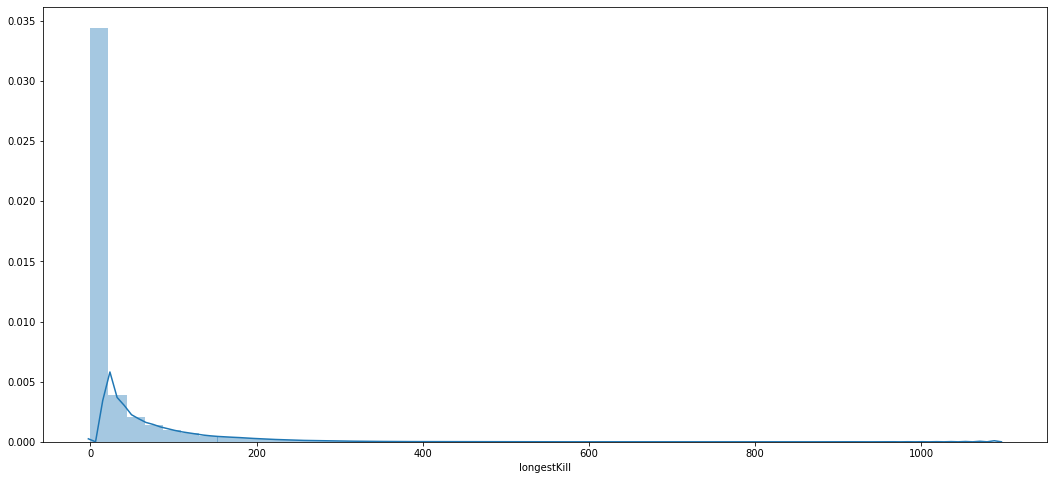

In [27]:
# histogram
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(df_train['longestKill'])

There are many kinds of guns in the game. So, as you can see in the picture below, the number of times you pick up a gun is several times.
> 游戏中有很多种枪。所以，正如你在下图中看到的，你拿起枪的次数是几次。

In [28]:
temp = df_train['weaponsAcquired'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='weaponsAcquired',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of weaponsAcquired',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

Among the guns are special guns aimed at fighters at close range, and there are sniper guns that are specially designed to match enemies at long distances (The range is fixed for each gun ). So over a certain distance, all were shot by a sniper rifle.

> 在这些枪支中，有一种是瞄准近距离战斗人员的特殊枪支，还有一种是专门设计用来对付远距离敌人的狙击枪(每把枪的射程都是固定的)。所以在一定距离内，所有人都被狙击步枪击中。

### headshotKills - not knocked.
HeadshotKills means that a bullet hit his head and  he died `right away`.  it is important that he died right away. 
- DBNOs : Number of enemy players knocked.

DBNOs variable means Number of enemy players `knocked`. Knocked is not dead, but can not act. so if you are knocked, your colleagues can save you (`revives` variable) but if you died? you don't save... :(

- Died picture
![](https://i.ytimg.com/vi/0qSFX2SBUho/maxresdefault.jpg)


- Knocked picture
![](https://i.ytimg.com/vi/EgLRYtUqxn4/maxresdefault.jpg)

[original picture link - above](https://www.google.co.kr/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwi2pp7i4-_dAhXGE7wKHdsJBNQQjRx6BAgBEAU&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D0qSFX2SBUho&psig=AOvVaw1JcDsctlYqqKvW_IyzuEue&ust=1538845327420883)

[original picture link - below](https://www.google.co.kr/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwj2ybrJ4-_dAhUJwbwKHcfCDlIQjRx6BAgBEAU&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DEgLRYtUqxn4&psig=AOvVaw27IBxucFCW7i3Dd55GSlSM&ust=1538845290684243)

In [29]:
temp = df_train['headshotKills'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='headshotKills',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of headshotKills',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [30]:
df_train['headshotKills'].value_counts()

0     3696116
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
20          3
23          3
26          3
27          2
21          2
31          2
34          2
40          1
42          1
41          1
46          1
39          1
35          1
64          1
Name: headshotKills, dtype: int64

In [31]:
temp = df_train['DBNOs'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='DBNOs',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of DBNOs',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

### what is difference boost vs heal?
Both of these variables are items that restore health. but the boosts immediately show the effect, and the heals show the effect slowly. 
> 这两个变量都是恢复健康状态的项。但boosts立刻显示出效果，而heals效果则很慢。

- boosts : Number of boost items used.
> boosts物品的数量 

![boosts](https://cdn.appuals.com/wp-content/uploads/2017/10/Battlegrounds-Healing-and-Boost-Items-Guide-5.png)

- heals : Number of healing items used.
> 治疗物品的数量

![heals](https://cdn.appuals.com/wp-content/uploads/2017/10/Battlegrounds-Healing-and-Boost-Items-Guide-1.png)

[original picture Link](https://appuals.com/playerunknowns-battlegrounds-healing-boost-items-guide/)


In [32]:
temp = df_train['boosts'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='boosts',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of boosts',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [33]:
temp = df_train['heals'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='heals',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of heals',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

### others

- damageDealt : Total damage dealt. Note: Self inflicted damage is subtracted. If it is not headshot, it does not die in one shot. So restores health by using` boosts` or `heals`. `damageDealt` means how many bullets have ever been hit.

> 伤害:全部伤害。注意:减去自己给自己造成的伤害。如果不是爆头，对手就不会死于一次枪击。所以用“boost”或“heals”来恢复健康。“damagedeal”指的是曾经打中人的伤害


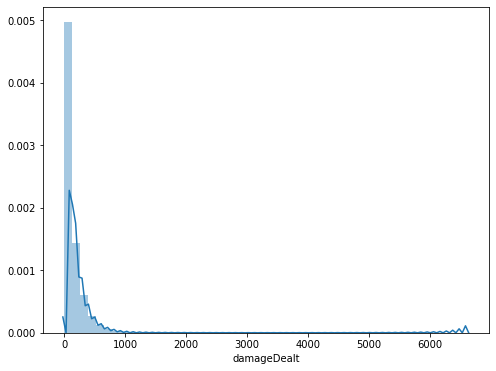

In [34]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['damageDealt'])

- revives : Number of times this player revived teammates. I said above,  if you knock, your teammates can save you. If a team member is saved, the revives are +1.

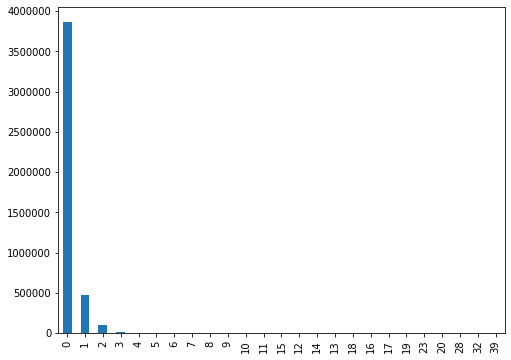

In [35]:
f, ax = plt.subplots(figsize=(8, 6))
df_train['revives'].value_counts().sort_values(ascending=False).plot.bar()
plt.show()

- walkDistance : Total distance traveled on foot measured in meters.

![](https://i.ytimg.com/vi/Ig_KOUqrSH8/maxresdefault.jpg)

[original picture link](https://www.google.co.kr/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwignNbp4u_dAhWFxbwKHVGICYAQjRx6BAgBEAU&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DIg_KOUqrSH8&psig=AOvVaw06O9ien8kWzTdVEG0Fki7e&ust=1538845052210260)

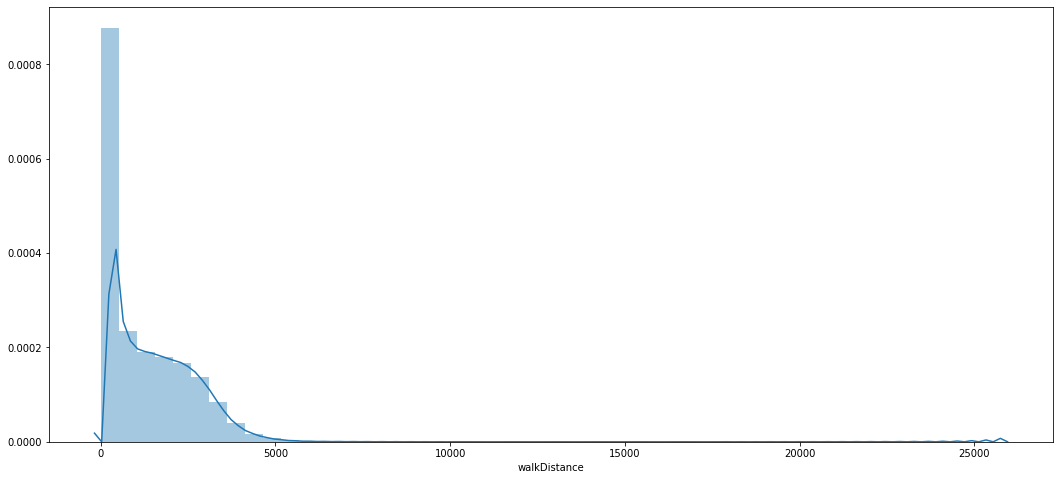

In [36]:
#histogram
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(df_train['walkDistance'])

- rideDistance : Total distance traveled in vehicles measured in meters. The PUBG game is so wide that it is hard to walk around. So I ride around VEHICLE as shown in the picture below.

![](http://file.gamedonga.co.kr/files/2017/04/04/pkbg089.jpg)

[original picture link](https://www.google.co.kr/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwjl7p784u_dAhVG6LwKHceWB3wQjRx6BAgBEAU&url=http%3A%2F%2Fgame.donga.com%2F86877%2F&psig=AOvVaw01B4xxH_3KBE8QpqBsFwmH&ust=1538845127758218)

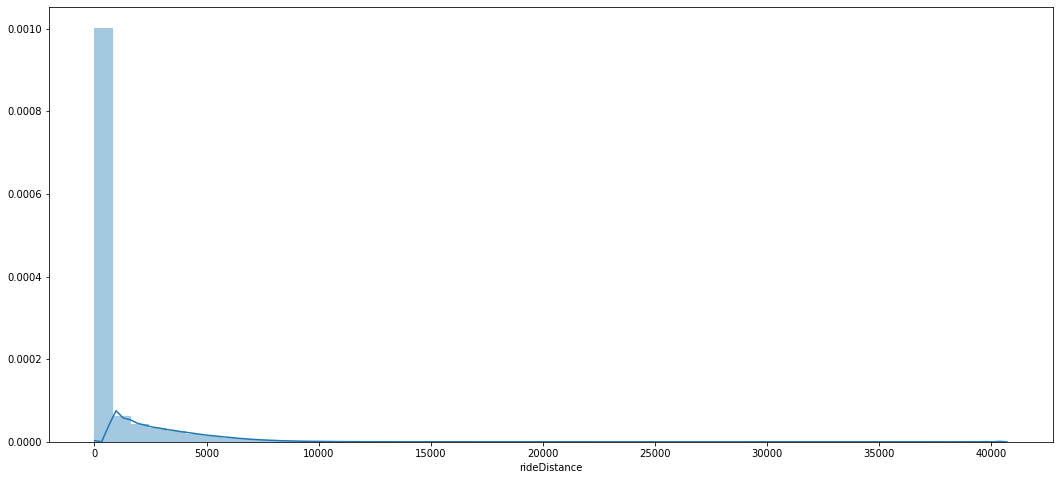

In [37]:
#histogram
f, ax = plt.subplots(figsize=(18, 8))
sns.distplot(df_train['rideDistance'])

- swimDistance: Total distance traveled by swimming measured in meters. The map is wide, and there are some kind of river. 

![](https://i.ytimg.com/vi/heUNpk8XaRU/maxresdefault.jpg)

[original picture link](https://www.google.co.kr/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwjT1e3d2e_dAhWMabwKHYh2CsAQjRx6BAgBEAU&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DheUNpk8XaRU&psig=AOvVaw2FnVjz97_tbgYfeHuGycut&ust=1538842587462044)


- vehicleDestroys: Number of vehicles destroyed.

In [38]:
temp = df_train['vehicleDestroys'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='vehicleDestroys',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of vehicleDestroys',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

In [39]:
df_train['vehicleDestroys'].value_counts()

0    4413212
1      32422
2       1223
3         95
4         11
5          3
Name: vehicleDestroys, dtype: int64

If you look at the above values, you will rarely destroy a vehicle. In fact, it is very natural. It is difficult to destroy the car. And there is no profit by destroying the car. Even so, the destruction of a car can be thought of in the following sense. 
》 如果你看了上面的值，你很少会摧毁一辆车。事实上，这是很自然的。这辆车很难毁坏。毁坏汽车是没有利润的。即便如此，汽车的毁坏还是可以从以下几个方面来考虑。

- The enemy was in the car and shot the car.
- The enemy hid the car in cover and shot the car.
- He broke a car with no meaning.
> -敌人在车里，向车开了枪。
> -敌人把车藏在掩体里，然后开枪打了车。
> -他毫无意义地弄坏了一辆车。

The third reason is very important. When you play games, you can meet a lot of strange people.

> 第三个原因非常重要。当你玩游戏的时候，你可以遇到很多奇怪的人。

- weaponsAcquired : Number of weapons picked up. This game is a using gun , but it does not give a gun from the beginning. So you have to go around the map and look for weapons. In the process, you can also have heals, boosts and vehicles.
> 武器数量:捡到的武器数量。这个游戏是一个使用枪，但一开始是没有枪的。所以你必须在地图上找武器。在这个过程中，你也可以有heals，boosts和vehicles。

![](https://t1.daumcdn.net/cfile/tistory/9904AA3359B201AA0C)

[original picture link](https://www.google.co.kr/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=2ahUKEwjtq9eM4-_dAhUK7bwKHeOjBPMQjRx6BAgBEAU&url=http%3A%2F%2Fhogod.tistory.com%2F23&psig=AOvVaw1SqPa1ImkjsfcThfY5nfgW&ust=1538845160945955)

In [40]:
temp = df_train['weaponsAcquired'].value_counts().sort_values(ascending=False)

#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp),
)
data = [trace]
layout = go.Layout(
    title = "",
    xaxis=dict(
        title='weaponsAcquired',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of weaponsAcquired',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

## 4. Simple EDA

### 4.1 Missing Values

In [43]:
df_train.isnull().count()

Id                 4446966
groupId            4446966
matchId            4446966
assists            4446966
boosts             4446966
damageDealt        4446966
DBNOs              4446966
headshotKills      4446966
heals              4446966
killPlace          4446966
killPoints         4446966
kills              4446966
killStreaks        4446966
longestKill        4446966
matchDuration      4446966
matchType          4446966
maxPlace           4446966
numGroups          4446966
rankPoints         4446966
revives            4446966
rideDistance       4446966
roadKills          4446966
swimDistance       4446966
teamKills          4446966
vehicleDestroys    4446966
walkDistance       4446966
weaponsAcquired    4446966
winPoints          4446966
winPlacePerc       4446966
dtype: int64

In [44]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [46]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False) # 空值总数
percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
winPlacePerc,1,2.248724e-07
longestKill,0,0.000000e+00
groupId,0,0.000000e+00
matchId,0,0.000000e+00
assists,0,0.000000e+00
boosts,0,0.000000e+00
damageDealt,0,0.000000e+00
DBNOs,0,0.000000e+00
headshotKills,0,0.000000e+00
heals,0,0.000000e+00


In [47]:
percent

winPlacePerc       2.248724e-07
longestKill        0.000000e+00
groupId            0.000000e+00
matchId            0.000000e+00
assists            0.000000e+00
boosts             0.000000e+00
damageDealt        0.000000e+00
DBNOs              0.000000e+00
headshotKills      0.000000e+00
heals              0.000000e+00
killPlace          0.000000e+00
killPoints         0.000000e+00
kills              0.000000e+00
killStreaks        0.000000e+00
matchDuration      0.000000e+00
winPoints          0.000000e+00
matchType          0.000000e+00
maxPlace           0.000000e+00
numGroups          0.000000e+00
rankPoints         0.000000e+00
revives            0.000000e+00
rideDistance       0.000000e+00
roadKills          0.000000e+00
swimDistance       0.000000e+00
teamKills          0.000000e+00
vehicleDestroys    0.000000e+00
walkDistance       0.000000e+00
weaponsAcquired    0.000000e+00
Id                 0.000000e+00
dtype: float64

In [50]:
#histogram
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data

winPlacePerc     2.248724e-07
longestKill      0.000000e+00
groupId          0.000000e+00
matchId          0.000000e+00
assists          0.000000e+00
boosts           0.000000e+00
damageDealt      0.000000e+00
DBNOs            0.000000e+00
headshotKills    0.000000e+00
heals            0.000000e+00
killPlace        0.000000e+00
killPoints       0.000000e+00
kills            0.000000e+00
killStreaks      0.000000e+00
matchDuration    0.000000e+00
winPoints        0.000000e+00
matchType        0.000000e+00
maxPlace         0.000000e+00
numGroups        0.000000e+00
rankPoints       0.000000e+00
dtype: float64

Text(0.5, 1.0, 'Total Missing Value (%) in Train')

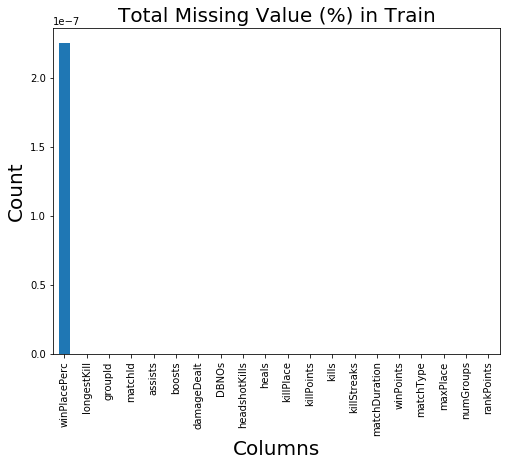

In [51]:
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Train", fontsize = 20)

There is not Missing Value

### 4.2 winPlacePerc (Target Value)

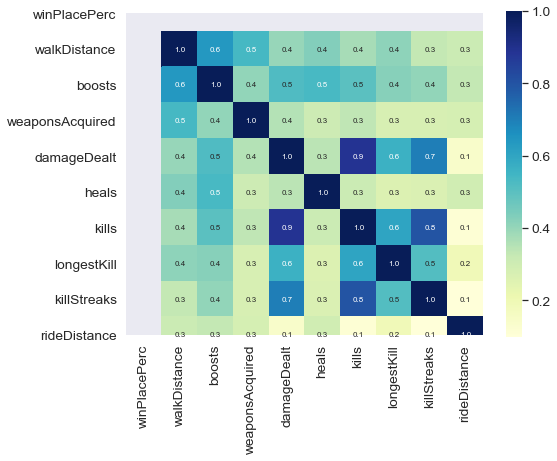

In [59]:
#winPlacePerc correlation matrix
k = 10 #number of variables for heatmap
corrmat = df_train.corr() 
cols = corrmat.nlargest(k, 'winPlacePerc').index # nlargest : Return this many descending sorted values
cm = np.corrcoef(df_train[cols].values.T) # correlation 
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(cm, cmap='YlGnBu',cbar=True, annot=True, square=True, fmt='.1f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 4.2.2 others

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


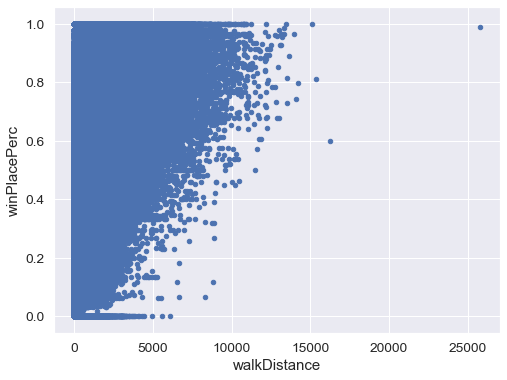

In [60]:
df_train.plot(x="walkDistance",y="winPlacePerc", kind="scatter", figsize = (8,6))

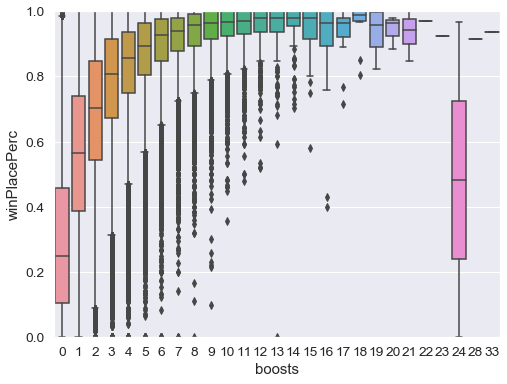

In [61]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='boosts', y="winPlacePerc", data=df_train)
fig.axis(ymin=0, ymax=1);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


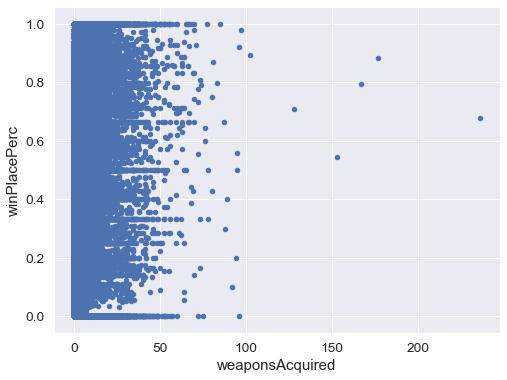

In [62]:
df_train.plot(x="weaponsAcquired",y="winPlacePerc", kind="scatter", figsize = (8,6))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


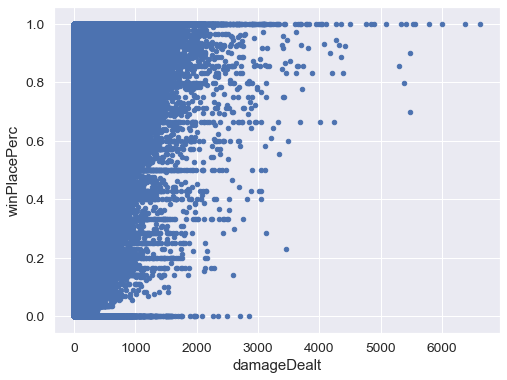

In [63]:
df_train.plot(x="damageDealt",y="winPlacePerc", kind="scatter", figsize = (8,6))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


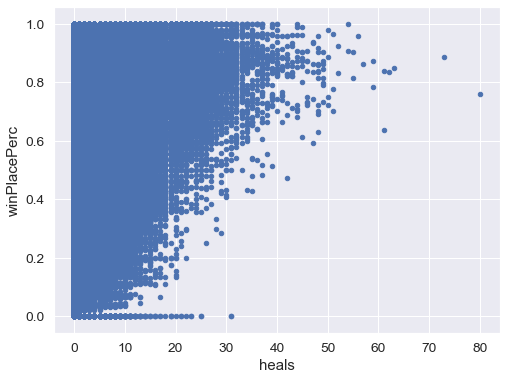

In [64]:
df_train.plot(x="heals",y="winPlacePerc", kind="scatter", figsize = (8,6))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


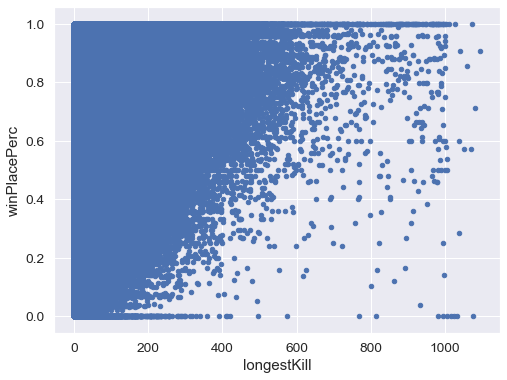

In [65]:
df_train.plot(x="longestKill",y="winPlacePerc", kind="scatter", figsize = (8,6))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


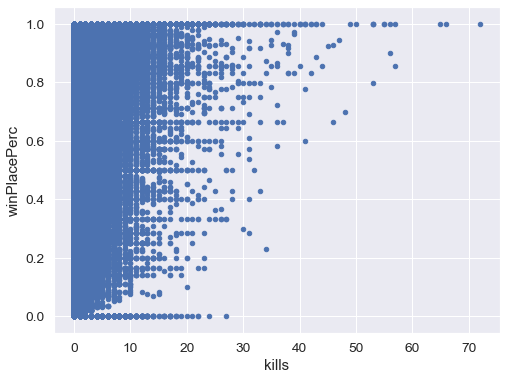

In [66]:
df_train.plot(x="kills",y="winPlacePerc", kind="scatter", figsize = (8,6))

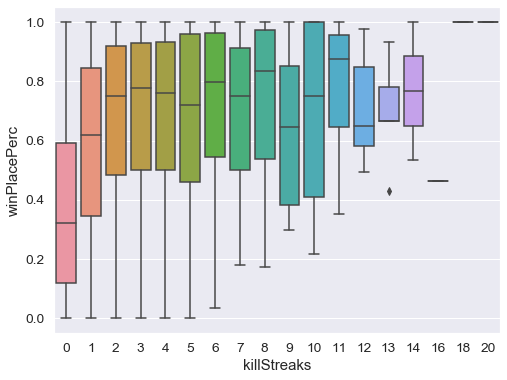

In [69]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='killStreaks', y="winPlacePerc", data=df_train)
#fig.axis(ymin=0, ymax=1);

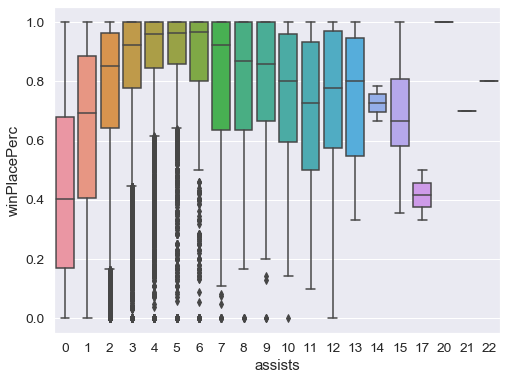

In [70]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='assists', y="winPlacePerc", data=df_train)
#fig.axis(ymin=0, ymax=1);

### what is changed ?
https://www.kaggle.com/chocozzz/updated-what-is-difference-before-data

## 5. Feature Engineering

### 5.1 headshot rate

In [71]:
df_train = df_train[df_train['Id']!='f70c74418bb064']

In [72]:
headshot = df_train[['kills','winPlacePerc','headshotKills']]
headshot['headshotrate'] = headshot['kills'] / headshot['headshotKills']

In [73]:
headshot.corr()

,kills,winPlacePerc,headshotKills,headshotrate
kills,1.000000,0.419915,0.674275,0.678770
winPlacePerc,0.419915,1.000000,0.277722,0.323686
headshotKills,0.674275,0.277722,1.000000,-0.082599
headshotrate,0.678770,0.323686,-0.082599,1.000000


In [74]:
del headshot

In [75]:
df_train['headshotrate'] = df_train['kills'] / df_train['headshotKills']
df_test['headshotrate'] = df_test['kills'] / df_test['headshotKills']

In [76]:
gc.collect()

36323

### 5.2 killStreak rate

In [77]:
killStreak = df_train[['kills','winPlacePerc','killStreaks']]
killStreak['killStreakrate'] = killStreak['killStreaks']/killStreak['kills']
killStreak.corr()

,kills,winPlacePerc,killStreaks,killStreakrate
kills,1.000000,0.419915,0.802500,-0.730883
winPlacePerc,0.419915,1.000000,0.377566,-0.386675
killStreaks,0.802500,0.377566,1.000000,-0.143883
killStreakrate,-0.730883,-0.386675,-0.143883,1.000000


- minus killStreakrate is better than killStreaks. so i delete killStreaks and use killStreakrate

### 5.3 health Items

In [78]:
healthitems = df_train[['heals','winPlacePerc','boosts']]
healthitems['healthitems'] = healthitems['heals'] + healthitems['boosts']
healthitems.corr()

,heals,winPlacePerc,boosts,healthitems
heals,1.000000,0.427856,0.535854,0.927683
winPlacePerc,0.427856,1.000000,0.634232,0.575997
boosts,0.535854,0.634232,1.000000,0.812341
healthitems,0.927683,0.575997,0.812341,1.000000


In [79]:
del healthitems

This is a bad variable. so don't use it

### 5.4 kills & assists 

In [80]:
kills = df_train[['assists','winPlacePerc','kills']]
kills['kills_assists'] = (kills['kills'] + kills['assists'])
kills.corr()

,assists,winPlacePerc,kills,kills_assists
assists,1.000000,0.299439,0.319690,0.592749
winPlacePerc,0.299439,1.000000,0.419915,0.453049
kills,0.319690,0.419915,1.000000,0.952618
kills_assists,0.592749,0.453049,0.952618,1.000000


so it is good. i use kills_assists and drop kills because of high corr

In [81]:
del df_train,df_test;
gc.collect()

100

### 5.5 statisticals feature
https://www.kaggle.com/anycode/simple-nn-baseline-3

In [ ]:
def feature_engineering(is_train=True,debug=True):
    test_idx = None
    if is_train: 
        print("processing train.csv")
        if debug == True:
            df = pd.read_csv('../data/train_V2.csv', nrows=10000)
        else:
            df = pd.read_csv('../data/train_V2.csv')           

        df = df[df['maxPlace'] > 1]
    else:
        print("processing test.csv")
        df = pd.read_csv('../data/test_V2.csv')
        test_idx = df.Id
    
    # df = reduce_mem_usage(df)
    # df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    # df = df[:100]
    
    print("remove some columns")
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    
    # matchType = pd.get_dummies(df['matchType'])
    # df = df.join(matchType)    
    
    y = None
    
    
    if is_train: 
        print("get target")
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)

    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    if is_train: 
        df_out = agg.reset_index()[['matchId','groupId']]
    else: 
        df_out = df[['matchId','groupId']]

    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    # print("get group sum feature")
    # agg = df.groupby(['matchId','groupId'])[features].agg('sum')
    # agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    # df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    # df_out = df_out.merge(agg_rank, suffixes=["_sum", "_sum_rank"], how='left', on=['matchId', 'groupId'])
    
    # print("get group sum feature")
    # agg = df.groupby(['matchId','groupId'])[features].agg('sum')
    # agg_rank = agg.groupby('matchId')[features].agg('sum')
    # df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    # df_out = df_out.merge(agg_rank.reset_index(), suffixes=["_sum", "_sum_pct"], how='left', on=['matchId', 'groupId'])
    
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    # print("get match type feature")
    # agg = df.groupby(['matchId'])[matchType.columns].agg('mean').reset_index()
    # df_out = df_out.merge(agg, suffixes=["", "_match_type"], how='left', on=['matchId'])
    
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    X = df_out
    
    feature_names = list(df_out.columns)

    del df, df_out, agg, agg_rank
    gc.collect()

    return X, y, feature_names, test_idx

x_train, y_train, train_columns, _ = feature_engineering(True,False)
x_test, _, _ , test_idx = feature_engineering(False,True)

In [ ]:
x_train['headshotrate'] = x_train['kills']/x_train['headshotKills']
x_test['headshotrate'] = x_test['kills']/x_test['headshotKills']

x_train['killStreakrate'] = x_train['killStreaks']/x_train['kills']
x_test['killStreakrate'] = x_test['killStreaks']/x_test['kills']

x_train['healthitems'] = x_train['heals'] + x_train['boosts']
x_test['healthitems'] = x_test['heals'] + x_test['boosts']

del x_train['heals'];del x_test['heals']

train_columns.append('headshotrate')
train_columns.append('killStreakrate')
train_columns.append('healthitems')
train_columns.remove('heals')

In [ ]:
x_train.shape

In [ ]:
x_train = reduce_mem_usage(x_train)
x_test = reduce_mem_usage(x_test)

## 6. LightGBM

In [ ]:
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")
# data manipulation

# model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

### Predict 

In [ ]:
# LightGBM
folds = KFold(n_splits=3,random_state=6)
oof_preds = np.zeros(x_train.shape[0])
sub_preds = np.zeros(x_test.shape[0])

start = time.time()
valid_score = 0

feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    trn_x, trn_y = x_train.iloc[trn_idx], y_train[trn_idx]
    val_x, val_y = x_train.iloc[val_idx], y_train[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)   
    
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':15000, 'early_stopping_rounds':100,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.9,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7
             }
    
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
    
    oof_preds[val_idx] = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
    oof_preds[oof_preds>1] = 1
    oof_preds[oof_preds<0] = 0
    sub_pred = lgb_model.predict(x_test, num_iteration=lgb_model.best_iteration) 
    sub_pred[sub_pred>1] = 1 # should be greater or equal to 1
    sub_pred[sub_pred<0] = 0 
    sub_preds += sub_pred/ folds.n_splits
    
    #print('Fold %2d MAE : %.6f' % (n_fold + 1, mean_absolute_error(val_y, oof_preds[val_idx])))
    #valid_score += mean_absolute_error(val_y, oof_preds[val_idx])
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_columns
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    gc.collect()
    
#print('Full MAE score %.6f' % mean_absolute_error(y_train, oof_preds))
end = time.time()
print("Take Time :",(end-start))

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
f, ax = plt.subplots(figsize=(14, 14))
plt.scatter(y_train, oof_preds)
plt.xlabel("y")
plt.ylabel("predict_y")
plt.show()

### Below trick in https://www.kaggle.com/anycode/simple-nn-baseline-4 , very nice kernel
LB 0.0011 better

In [ ]:
df_test = pd.read_csv('../input/' + 'test_V2.csv')
pred = sub_preds
print("fix winPlacePerc")
for i in range(len(df_test)):
    winPlacePerc = pred[i]
    maxPlace = int(df_test.iloc[i]['maxPlace'])
    if maxPlace == 0:
        winPlacePerc = 0.0
    elif maxPlace == 1:
        winPlacePerc = 1.0
    else:
        gap = 1.0 / (maxPlace - 1)
        winPlacePerc = round(winPlacePerc / gap) * gap
    
    if winPlacePerc < 0: winPlacePerc = 0.0
    if winPlacePerc > 1: winPlacePerc = 1.0    
    pred[i] = winPlacePerc

    if (i + 1) % 100000 == 0:
        print(i, flush=True, end=" ")

df_test['winPlacePerc'] = pred

submission = df_test[['Id', 'winPlacePerc']]
submission.to_csv('submission.csv', index=False)

### If there is any part of the data that you do not understand, I will answer with a comment. I will continue to add content.